# 匯入套件與載入檔案

In [1]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
#import nltk     需要nltk套件時在反註解下載
#nltk.download() 需要nltk套件時在反註解下載
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from wordcloud import WordCloud,STOPWORDS

#分類要用的
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import SGDClassifier
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split

#BERT要用的
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text 

In [2]:
#kaggle創notebook時會有這塊?
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

In [3]:
train = pd.read_csv('./datasets/train.csv')
test = pd.read_csv('./datasets/test.csv')
sample=pd.read_csv('./datasets/sample_submission.csv')

# Exploratory Data Analysis (EDA) 

In [4]:
train.head(10)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


In [5]:
test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [6]:
print('Trining dataset has {} rows and {} columns'.format(train.shape[0],train.shape[1]))
print('Test dataset has {} rows and {} columns'.format(test.shape[0],test.shape[1]))

Trining dataset has 7613 rows and 5 columns
Test dataset has 3263 rows and 4 columns


c:\Users\gopl0\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


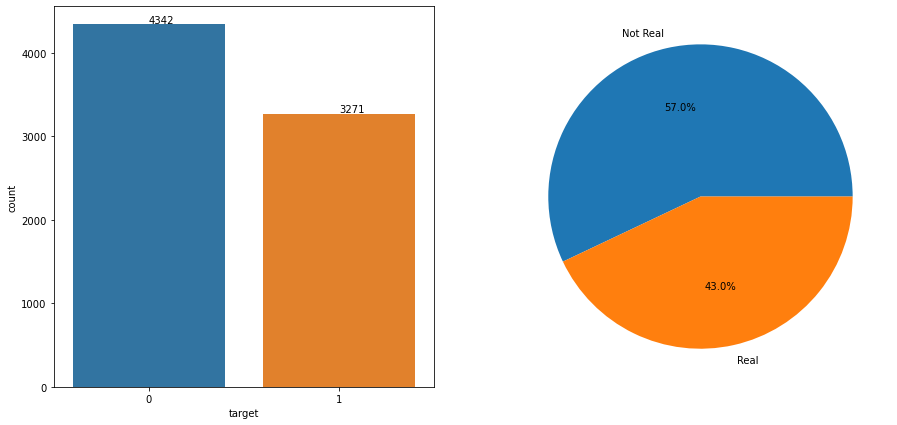

In [7]:
def barh(ax):
    
    for p in ax.patches:
        val = p.get_height() #height of the bar
        x = p.get_x()+ p.get_width()/2 #x-position 
        y = p.get_y() + p.get_height() + 15 #y-position
        ax.annotate(round(val,2),(x,y))

plt.figure(figsize=(15,7))
plt.subplot(1,2,1)
ax = sns.countplot(train['target'])
barh(ax)
labels = ['Not Real','Real']
plt.subplot(1,2,2)
plt.pie(train.groupby(['target']).count()['id'],labels=labels, autopct='%1.1f%%')

plt.show()

In [8]:
train[train["target"] == 1]["text"].values[:3]

array(['Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all',
       'Forest fire near La Ronge Sask. Canada',
       "All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected"],
      dtype=object)

In [9]:
train[train["target"] == 0]["text"].values[:3]

array(["What's up man?", 'I love fruits', 'Summer is lovely'],
      dtype=object)

In [10]:
train.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

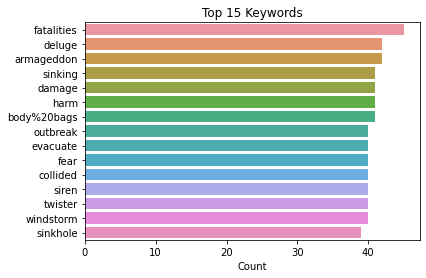

In [11]:
keywords_vc = pd.DataFrame({"Count": train["keyword"].value_counts()})
sns.barplot(y=keywords_vc[0:15].index, x=keywords_vc[0:15]["Count"], orient='h')
plt.title("Top 15 Keywords")
plt.show()

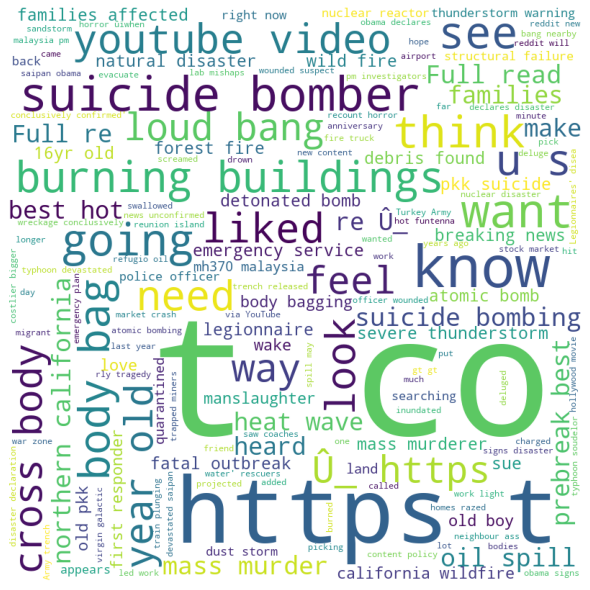

In [12]:
stopwordSet = set(STOPWORDS)
tweet_words = ''
for tweet in train['text']:
    tweet = str(tweet)
    tokens = tweet.split()
    for i in range(len(tokens)):
        tokens[i] = tokens[i].lower()
        tweet_words += ' '.join(tokens) + ' '
        
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                stopwords = stopwordSet,
                min_font_size = 10).generate(tweet_words)
#畫WordCloud圖                      
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
 
plt.show()

# Data Cleaning & Preprocessing (regular expression)

In [13]:
train.drop(['id','location','keyword'],axis=1,inplace=True)

In [14]:
def preprocess_text(text):
    
    text=re.sub('<[^>]*>','',text)
    text=re.sub("[^A-Za-z" "]+"," ",text).lower()
    text=re.sub("[0-9" "]+"," ",text)
    emojis=re.findall('(?::|;|=)(?:-)?(?:)|(|D|P)',text)
    text=re.sub('[\W]+',' ',text.lower()) + ' '.join(emojis).replace('-','')

    text_tokens = word_tokenize(text)
    stop_words = set(stopwords.words('english'))

    #移除停用字
    filtered_text = []
    for w in text_tokens:
        if w not in stop_words:
            filtered_text.append(w)

    #把他回傳給句子
    return " ".join(filtered_text)

In [15]:
train['text'] = train.text.apply(preprocess_text)

In [16]:
train.head()

,text,target
0,deeds reason earthquake may allah forgive us,1
1,forest fire near la ronge sask canada,1
2,residents asked shelter place notified officer...,1
3,people receive wildfires evacuation orders cal...,1
4,got sent photo ruby alaska smoke wildfires pou...,1


# 使用RandomForestClassifier、ExtraTreesClassifier、SGDClassifier

In [17]:
cv = CountVectorizer(max_features = 3000)

In [18]:
X = cv.fit_transform(train['text']).toarray()

Y = train["target"]

In [19]:
X_test = cv.transform(test["text"]).toarray()

In [20]:
print(X.shape, X_test.shape)

(7613, 3000) (3263, 3000)


In [21]:
x_train,x_test,y_train,y_test = train_test_split(X,Y)

In [22]:
print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(5709, 3000)
(1904, 3000)
(5709,)
(1904,)


In [23]:
models  = {
    "RandomForestClassifier" : make_pipeline(RandomForestClassifier()),
    "ExtraTreesClassifier" : make_pipeline(ExtraTreesClassifier()),
    "SGDClassifier" : make_pipeline(SGDClassifier())
}

In [24]:
fit_models = {}
for algo,pipeline in models.items():
    model = pipeline.fit(x_train,y_train)
    fit_models[algo] = model

In [25]:
#訓練數據的分數
for model in fit_models:
    print(f" {model} : {fit_models[model].score(x_train,y_train)*100}%")

 RandomForestClassifier : 98.75634962340165%
 ExtraTreesClassifier : 98.75634962340165%
 SGDClassifier : 94.49991241898756%


In [26]:
#測試數據的分數
scores = {}
for model in fit_models:
    print(f" {model} : {fit_models[model].score(x_test,y_test)*100:.2f}%")
    scores[model] = fit_models[model].score(x_test,y_test)

 RandomForestClassifier : 77.31%
 ExtraTreesClassifier : 77.00%
 SGDClassifier : 76.52%


In [27]:
#檢查sample樣本數據
sample.head()

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0


## RandomForestClassifier 分類後的結果

In [28]:
randomforest_predictions = fit_models["RandomForestClassifier"].predict(X_test)
randomforest_predictions[:20]

array([0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
      dtype=int64)

In [29]:
sample["target"] = randomforest_predictions

In [30]:
sample.target.value_counts()

0    2132
1    1131
Name: target, dtype: int64

In [31]:
sample

,id,target
0,0,0
1,2,1
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


## ExtraTreesClassifier 分類後的結果

In [32]:
extratrees_predictions = fit_models["ExtraTreesClassifier"].predict(X_test)
extratrees_predictions[:20]

array([0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
      dtype=int64)

In [33]:
sample["target"] = extratrees_predictions

In [34]:
sample.target.value_counts()

0    2026
1    1237
Name: target, dtype: int64

In [35]:
sample

,id,target
0,0,0
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


## SGDClassifier分類後的結果

In [36]:
sgd_predictions = fit_models["SGDClassifier"].predict(X_test)
sgd_predictions[:20]

array([1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
      dtype=int64)

In [37]:
sample["target"] = sgd_predictions

In [38]:
sample.target.value_counts()

0    2043
1    1220
Name: target, dtype: int64

In [39]:
sample

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


# BERT 

In [40]:
X_train = train["text"]
y_train = train["target"]

In [41]:
preprocess_url = "https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3"
encoder_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4"

In [42]:
bert_preprocess = hub.KerasLayer(preprocess_url)
bert_encoder = hub.KerasLayer(encoder_url)

In [43]:
def get_sentence_embeding(sentences):
    preprocessed_text = bert_preprocess(sentences)
    return bert_encoder(preprocessed_text)['pooled_output']

In [44]:
#Bert layers
text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
preprocessed_text = bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#Neural network layers
layer = tf.keras.layers.Dropout(0.1, name="dropout1")(outputs['pooled_output'])
layer = tf.keras.layers.Dense(100,  activation='relu', name='output1')(layer)
layer = tf.keras.layers.Dropout(0.2, name="dropout2")(layer)
layer = tf.keras.layers.Dense(50, activation='relu', name='output2')(layer)
layer = tf.keras.layers.Dropout(0.2, name="dropout3")(layer)
layer = tf.keras.layers.Dense(1, activation='sigmoid', name="output")(layer)

#使用inputs和outputs建立最後的model
model = tf.keras.Model(inputs=[text_input], outputs = [layer])

In [45]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [46]:
model.compile(optimizer='Adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

In [47]:
history = model.fit(X_train ,y_train, epochs=10)

Epoch 1/10
238/238 [==============================] - 93s 335ms/step - loss: 0.6344 - accuracy: 0.6456
Epoch 2/10
238/238 [==============================] - 81s 341ms/step - loss: 0.5710 - accuracy: 0.7190
Epoch 3/10
238/238 [==============================] - 79s 333ms/step - loss: 0.5610 - accuracy: 0.7306
Epoch 4/10
238/238 [==============================] - 80s 337ms/step - loss: 0.5356 - accuracy: 0.7453
Epoch 5/10
238/238 [==============================] - 81s 342ms/step - loss: 0.5346 - accuracy: 0.7471
Epoch 6/10
238/238 [==============================] - 82s 346ms/step - loss: 0.5310 - accuracy: 0.7465
Epoch 7/10
238/238 [==============================] - 82s 343ms/step - loss: 0.5314 - accuracy: 0.7498
Epoch 8/10
238/238 [==============================] - 80s 337ms/step - loss: 0.5280 - accuracy: 0.7500
Epoch 9/10
238/238 [==============================] - 80s 338ms/step - loss: 0.5218 - accuracy: 0.7552
Epoch 10/10
238/238 [==============================] - 80s 337ms/step - l

In [48]:
X_test = test.drop(["id","keyword", "location"], axis = 1)

## BERT分類後的結果

In [49]:
bert_predictions = model.predict(X_test)
bert_predictions=bert_predictions.flatten()
bert_predictions=np.where(bert_predictions > 0.5,1,0)

102/102 [==============================] - 35s 337ms/step


In [50]:
sample["target"]=bert_predictions

In [51]:
sample.target.value_counts()

0    2314
1     949
Name: target, dtype: int64

In [52]:
sample

,id,target
0,0,0
1,2,0
2,3,0
3,9,1
4,11,1
...,...,...
3258,10861,0
3259,10865,1
3260,10868,1
3261,10874,0
